In [1]:
# import general libraries
import numpy as np
from scipy.signal import periodogram
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
# import from the file multiplayer_prisoners_dilemma.py
from multiplayer_prisoners_dilemma import QLearningAgent
from multiplayer_prisoners_dilemma import Game
from multiplayer_prisoners_dilemma import Simulation

# Figure 1

In [2]:
# Figure 1: Stability analysis for the prisoner's dilemma in the deterministic model (2019)
S, P, R, T = 0, 1, 3, 5
R_i_a1_a2 = np.array([[[R, S], 
                       [T, P]],
                       [[R, T], 
                        [S, P]]])

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_PD(action_vector, player_id):
    # reward tensor R_i_a0_a1. first index is the agent, second index is the action taken by the agent 1, third index is the action taken by the agent 2
    R_i_a1_a2 = np.array([[[R, S], 
                        [T, P]],
                        [[R, T], 
                        [S, P]]])
    return R_i_a1_a2[player_id, action_vector[0], action_vector[1]]

In [3]:
def calculate_fixed_point_policy_for_2x2_matrix_games(R_i_a0_a1, temperature):
    ''' 
    A function that calculates the fixed point policy for a 2x2 matrix game with two agents.
    In reference to the prisoner's dilemma, the notation of the action variables are C and D, but the function is general for any 2x2 matrix game,
    where the first action is indexed by 0 and the second action is indexed by 1.

    Input:
    - R_i_a0_a1: Reward tensor of shape (2, 2, 2) for two agents with two actions each
    - temperature: Temperature parameter that scales the logit function

    Output:
    - results: Fixed point policy for the two agents: [p_1_C, p_2_C]
    '''
    R_i_a0_a1 = R_i_a0_a1
    temperature = temperature
    # rewards for agent 1
    R_1_CC = R_i_a0_a1[0,0,0] # Reward for agent 1 if both agents choose action C
    R_1_CD = R_i_a0_a1[0,0,1] # Reward for agent 1 if agent 1 chooses C and agent 2 chooses D
    R_1_DC = R_i_a0_a1[0,1,0] # Reward for agent 1 if agent 1 chooses D and agent 2 chooses C
    R_1_DD = R_i_a0_a1[0,1,1] # Reward for agent 1 if both agents choose action D
    # rewards for agent 2
    R_2_CC = R_i_a0_a1[1,0,0] # Reward for agent 2 if both agents choose action C
    R_2_CD = R_i_a0_a1[1,0,1] # Reward for agent 2 if agent 1 chooses C and agent 2 chooses D
    R_2_DC = R_i_a0_a1[1,1,0] # Reward for agent 2 if agent 1 chooses D and agent 2 chooses C
    R_2_DD = R_i_a0_a1[1,1,1] # Reward for agent 2 if both agents choose action D

    def f1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_CC + (1-p_2_C)*R_1_CD)/temperature ) 

    def g1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_DC + (1-p_2_C)*R_1_DD)/temperature )
    
    def f2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CC + (1-p_1_C)*R_2_DC)/temperature )

    def g2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CD + (1-p_1_C)*R_2_DD)/temperature )
    
    def fixed_point_equations(variables, temperature = temperature):
        p_1_C, p_2_C = variables
        eq1 = p_1_C - (f1(p_2_C, temperature) / (f1(p_2_C, temperature) + g1(p_2_C, temperature)))
        eq2 = p_2_C - (f2(p_1_C, temperature) / (f2(p_1_C, temperature) + g2(p_1_C, temperature)))
        return [eq1, eq2]
    
    initial_guess = [0.5, 0.5]
    results = fsolve(fixed_point_equations, initial_guess)
    return results

def jacobi_matrix_for_2x2_matrix_games(R_i_a0_a1, p_i_ai, temperature):
    '''
    A function that calculates the Jacobian matrix of a given fixed point in policy space (policy tensor p_i_ai) for a 2x2 matrix game with two agents.
    In reference to the prisoner's dilemma, the notation of the action variables are C and D, but the function is general for any 2x2 matrix game,
    where the first action is indexed by 0 and the second action is indexed by 1.

    Input:
    - R_i_a0_a1: Reward tensor of shape (2, 2, 2) for two agents with two actions each
    - p_i_ai: Policy tensor of shape (2, 2) for two agents with two actions each
    - temperature: Temperature parameter that scales the logit function

    Output:
    - J: Jacobian matrix of the fixed point in policy space
    '''
    # rewards for agent 1
    R_1_CC = R_i_a0_a1[0,0,0] # Reward for agent 1 if both agents choose action C
    R_1_CD = R_i_a0_a1[0,0,1] # Reward for agent 1 if agent 1 chooses C and agent 2 chooses D
    R_1_DC = R_i_a0_a1[0,1,0] # Reward for agent 1 if agent 1 chooses D and agent 2 chooses C
    R_1_DD = R_i_a0_a1[0,1,1] # Reward for agent 1 if both agents choose action D
    # rewards for agent 2
    R_2_CC = R_i_a0_a1[1,0,0] # Reward for agent 2 if both agents choose action C
    R_2_CD = R_i_a0_a1[1,0,1] # Reward for agent 2 if agent 1 chooses C and agent 2 chooses D
    R_2_DC = R_i_a0_a1[1,1,0] # Reward for agent 2 if agent 1 chooses D and agent 2 chooses C
    R_2_DD = R_i_a0_a1[1,1,1] # Reward for agent 2 if both agents choose action D
    # probabilities for agent 1
    p_1_C = p_i_ai[0,0] # Probability for agent 1 to choose action C
    p_2_C = p_i_ai[1,0] # Probability for agent 2 to choose action C

    def f1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_CC + (1-p_2_C)*R_1_CD)/temperature ) 

    def g1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_DC + (1-p_2_C)*R_1_DD)/temperature )

    def f2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CC + (1-p_1_C)*R_2_DC)/temperature )

    def g2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CD + (1-p_1_C)*R_2_DD)/temperature )

    partial_p_1_p_2_C = (R_1_CC - R_1_CD - R_1_DC + R_1_DD) * 1/temperature * f1(p_2_C, temperature) * g1(p_2_C, temperature) / (f1(p_2_C, temperature) + g1(p_2_C, temperature))**2 
    partial_p_2_C_p_1 = (R_2_CC - R_2_DC - R_2_CD + R_2_DD) * 1/temperature * f2(p_1_C, temperature) * g2(p_1_C, temperature) / (f2(p_1_C, temperature) + g2(p_1_C, temperature))**2
    return np.array([[0, partial_p_1_p_2_C],
                    [partial_p_2_C_p_1, 0]])

def stability_analysis(R_i_a0_a1, temperature_array):
    '''
    A function that conducts a stability analysis for the prisoner's dilemma for a range of temperatures.
    The stability analysis includes the calculation of the fixed point policy and the eigenvalues and eigenvectors of the Jacobian matrix at the fixed point.

    Input:
    - R_i_a0_a1: Reward tensor of shape (2, 2, 2) for two agents with two actions each
    - temperature_array: Array of temperatures for which the stability analysis is conducted

    Output:
    - p_fixed_point_array: Array of fixed point policies for the two agents
    - eigenvalues_array: Array of eigenvalues of the Jacobian matrix at the fixed point
    - eigenvectors_array: Array of eigenvectors of the Jacobian matrix at the fixed point
    '''
    p_fixed_point_array = np.zeros((len(temperature_array), 2))
    eigenvalues_array = np.zeros((len(temperature_array), 2))
    eigenvectors_array = np.zeros((len(temperature_array), 2, 2))
    for i in range(len(temperature_array)):
        temperature = temperature_array[i]
        # Calculate the fixed point policy for the prisoner's dilemma for given temperature
        p_fixed_point = calculate_fixed_point_policy_for_2x2_matrix_games(R_i_a0_a1, temperature)
        # update the probability tensor p_i_ai with the fixed point policy
        p_i_ai = np.array([[p_fixed_point[0], 1 - p_fixed_point[0]],
                        [p_fixed_point[1], 1 - p_fixed_point[1]]])
        # Calculate the Jacobian matrix for the prisoner's dilemma at the fixed point
        J = jacobi_matrix_for_2x2_matrix_games(R_i_a0_a1, p_i_ai, temperature)
        eigenvalues, eigenvectors = np.linalg.eig(J)

        # store in arrays
        p_fixed_point_array[i] = p_fixed_point
        eigenvalues_array[i] = eigenvalues
        eigenvectors_array[i] = eigenvectors
    return p_fixed_point_array, eigenvalues_array, eigenvectors_array

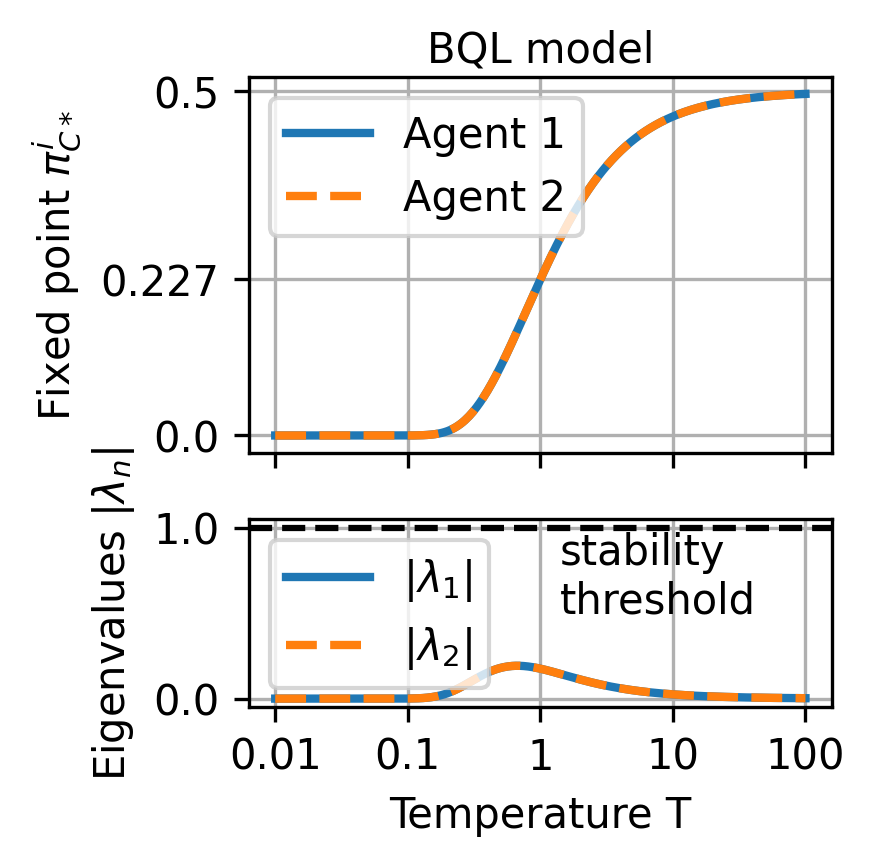

In [4]:
# FIGURE 1a
# conduct the stability analysis for the prisoner's dilemma for a range of temperatures
temperature_array = np.linspace(0.01, 100, int(1e4))
p_fixed_point_array, eigenvalues_array, eigenvectors_array = stability_analysis(R_i_a1_a2, temperature_array)

# Create subplots
# set the figure size
figsize1 = (3, 3)
figsize2 = (3, 3)
dpi = 300
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize1, dpi=dpi, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
linewidth = 2

def plot_stability_analysis_old_dynamics(p_fixed_point_array, eigenvalues_array, temperature_array):
    '''
    A function that plots the results of the stability analysis for the prisoner's dilemma.

    Input:
    - p_fixed_point_array: Array of fixed point policies for the two agents
    - eigenvalues_array: Array of eigenvalues of the Jacobian matrix at the fixed point
    - temperature_array: Array of temperatures for which the stability analysis is conducted

    Output:
    - Plot of the fixed point policy and the eigenvalues of the Jacobian matrix as a function of temperature
    '''
    # Plot the fixed point policy for the prisoner's dilemma as a function of temperature
    ax1.plot(temperature_array, p_fixed_point_array[:,0], label='Agent 1', linewidth=linewidth)
    ax1.plot(temperature_array, p_fixed_point_array[:,1], label='Agent 2', linestyle='--', linewidth=linewidth)
    ax1.set_ylabel(r'Fixed point $\pi^i_{C*}$')
    ax1.set_yticks([0.0, 0.227, 0.5])
    ax1.set_yticklabels(['0.0', '0.227', '0.5'])
    ax1.set_xscale('log')
    ax1.grid()
    ax1.legend(loc='upper left')
    #ax1.set_title('Fixed Point Policy and Eigenvalues as a Function of Temperature')

    # Plot the absolute eigenvalues of the Jacobian matrix as a function of temperature
    ax2.plot(temperature_array, abs(eigenvalues_array[:,0]), label=f'$|\lambda_1|$', linewidth=linewidth)
    ax2.plot(temperature_array, abs(eigenvalues_array[:,1]), label=f'$|\lambda_2|$', linestyle='--', linewidth=linewidth)
    ax2.axhline(y=1, color='black', linestyle='--')
    # underlay the text with white background
    ax2.text(1.4, 0.5, 'stability\nthreshold', rotation=0)
    ax2.set_yticks([0.0, 1.])
    ax2.set_yticklabels(['0.0', '1.0'])
    ax2.set_xticks([0.01, 0.1, 1, 10, 100])
    ax2.set_xticklabels(['0.01', '0.1', '1', '10', '100'])
    ax2.set_xlabel('Temperature T')
    ax2.set_ylabel('Eigenvalues $|\lambda_n|$')
    #ax2.set_xscale('log')
    ax2.grid()
    ax2.legend(loc='upper left')

    # title
    ax1.text(0.5, 1.07, 'BQL model', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

    # Adjust layout
    plt.tight_layout()
    plt.savefig('Figures/PaperFigures/Fig2_II_PD_DetModel_2019_StabilityAnalysis.pdf', dpi=dpi)
    plt.show()
    
plot_stability_analysis_old_dynamics(p_fixed_point_array, eigenvalues_array, temperature_array)

Initial guess: [0, 0], Solution: (0.227, 0.227)
Initial guess: [0.3333333333333333, 0.3333333333333333], Solution: (0.227, 0.227)
Initial guess: [0.5, 0.5], Solution: (0.227, 0.227)
Initial guess: [0.6666666666666666, 0.6666666666666666], Solution: (0.227, 0.227)
Initial guess: [1, 1], Solution: (0.227, 0.227)


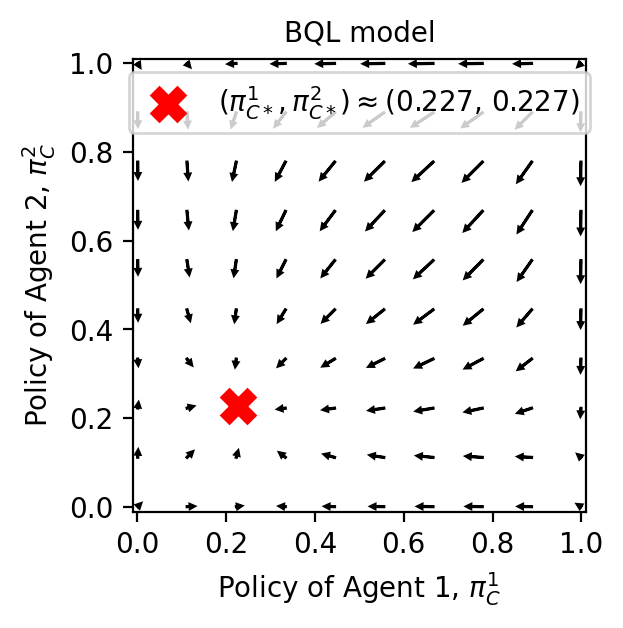

In [5]:

# FIGURE 1b: Arrow plot for the prisoner's dilemma in the deterministic model (2019)
# use the multiplayer_prisoners_dilemma.py file to generate the the phase space plot for the prisoner's dilemma in the deterministic model (2019)

# game parameters
num_players = 2
action_space = np.array([0 ,  1], dtype=float) # (0 = cooperate, 1 = defect)
# define the agents
agent_pair = [QLearningAgent, QLearningAgent]
learning_rate = 0.01
selection_method = "Boltzmann" 
temperature = 1
# Create a list of agents
agents = [agent_pair[i](player_id = i, 
                action_space = action_space,
                num_players = num_players,
                selection_method = selection_method,
                reward_func = reward_matrix_for_two_player_PD,
                temperature = temperature,
                learning_rate = learning_rate,
                )       
                for i in range(num_players)]

# Create a game and a Simulation
game = Game(agents = agents)
simulation = Simulation()

# generate arrow probabilities for the complete 1x1 square with a step size of 0.01
x = np.linspace(0.001, 0.999, 10)
initial_arrow_probabilities = [(x[i], x[j]) for i in range(len(x)) for j in range(len(x))]
cmap = None
dpi = 200
fig2 = simulation.arrowplot(agents, initial_arrow_probabilities=initial_arrow_probabilities, 
                     cmap=cmap, 
                     save_path=f"Figures/PaperFigures/Fig2_II_PD_arrowplot_T_{temperature}.pdf",  
                     title=f'BQL model', fontsize=None,
                     #figsize=figsize2, 
                     figsize=(3,3), 
                     marker_size=100, dpi=dpi)

(1000, 1000)
(1000, 1000)
Fixed point: p^1_C = 0.22675064483435223, p^2_C = 0.22675064483435223


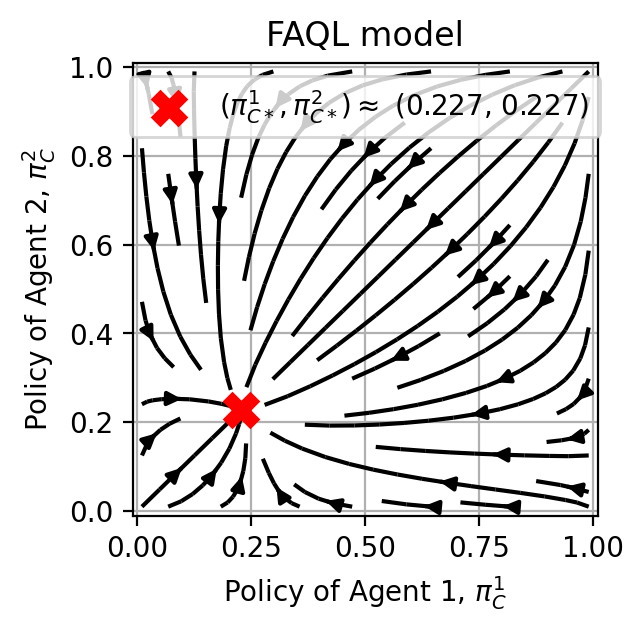

In [6]:
# For the FAQL model 
# Parameters
learning_rate = 0.01
temperature = 1

# Define the differential equations
def derivatives(p_1_C, p_2_C):
    R_1_CC, R_1_CD, R_1_DC, R_1_DD = R_i_a1_a2[0, 0, 0], R_i_a1_a2[0, 0, 1], R_i_a1_a2[0, 1, 0], R_i_a1_a2[0, 1, 1]
    R_2_CC, R_2_CD, R_2_DC, R_2_DD = R_i_a1_a2[1, 0, 0], R_i_a1_a2[1, 0, 1], R_i_a1_a2[1, 1, 0], R_i_a1_a2[1, 1, 1]
    
    Exp_R_1_C = p_2_C * R_1_CC + (1 - p_2_C) * R_1_CD
    Exp_R_1_D = p_2_C * R_1_DC + (1 - p_2_C) * R_1_DD
    Exp_R_2_C = p_1_C * R_2_CC + (1 - p_1_C) * R_2_DC
    Exp_R_2_D = p_1_C * R_2_CD + (1 - p_1_C) * R_2_DD
    
    p_1_C_derivative = learning_rate / temperature * p_1_C * ( Exp_R_1_C - (p_1_C * Exp_R_1_C + (1 - p_1_C) * Exp_R_1_D) ) + learning_rate * p_1_C * (p_1_C * np.log(p_1_C/p_1_C) + (1 - p_1_C) * np.log((1 - p_1_C) / p_1_C))
    p_2_C_derivative = learning_rate / temperature * p_2_C * ( Exp_R_2_C - (p_2_C * Exp_R_2_C + (1 - p_2_C) * Exp_R_2_D) ) + learning_rate * p_2_C * (p_2_C * np.log(p_2_C/p_2_C) + (1 - p_2_C) * np.log((1 - p_2_C) / p_2_C))
    
    return p_1_C_derivative, p_2_C_derivative

# Create a grid of points in the phase space
Grid_size = int(1e3)
p_1_C_values = np.linspace(0.01, 0.99, Grid_size)
p_2_C_values = np.linspace(0.01, 0.99, Grid_size)
P_1_C, P_2_C = np.meshgrid(p_1_C_values, p_2_C_values)
print(P_1_C.shape)

# Compute the derivatives at each point in the grid
P_1_C_derivative, P_2_C_derivative = derivatives(P_1_C, P_2_C)
print(P_1_C_derivative.shape)

# Define the system of equations for the fixed point
def fixed_point_equations(variables):
    p_1_C, p_2_C = variables
    p_1_C_derivative, p_2_C_derivative = derivatives(p_1_C, p_2_C)
    return [p_1_C_derivative, p_2_C_derivative]
# Initial guess for the fixed point
initial_guess = [0.5, 0.5]
# Solve for the fixed point
fixed_point = fsolve(fixed_point_equations, initial_guess)
print(f"Fixed point: p^1_C = {fixed_point[0]}, p^2_C = {fixed_point[1]}")

figsize = (3,3)
dpi = 200
fig3 = plt.figure(figsize=figsize, dpi=dpi)
# streamplot
plt.streamplot(P_1_C, P_2_C, P_1_C_derivative, P_2_C_derivative, color='black', density=0.6)
plt.scatter(fixed_point[0], fixed_point[1], label=r'$(\pi^1_{C*}, \pi^2_{C*}) \approx$ '+f'({fixed_point[0]:.3f}, {fixed_point[1]:.3f})', marker='x', s=100, linewidth=5, color='red', zorder=11)
plt.xlabel(r'Policy of Agent 1, $\pi^1_C$')
plt.ylabel(r'Policy of Agent 2, $\pi^2_C$')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.title('FAQL model')
plt.grid()
plt.legend(loc='upper center')
plt.savefig(f'Figures/PaperFigures/Fig2_II_PD_Tuyls_streamline_T_{temperature}.pdf', dpi=dpi)
plt.show()